In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [119]:
BATCH_SIZE = 15
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=400

In [120]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plantvillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 149 files belonging to 6 classes.


In [121]:
class_names = dataset.class_names
class_names

['A', 'B', 'C', 'D', 'E', 'K']

In [122]:
len(dataset)

10

In [123]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(15, 256, 256, 3)
[3 1 3 4 3 1 5 1 1 0 0 2 2 3 0]


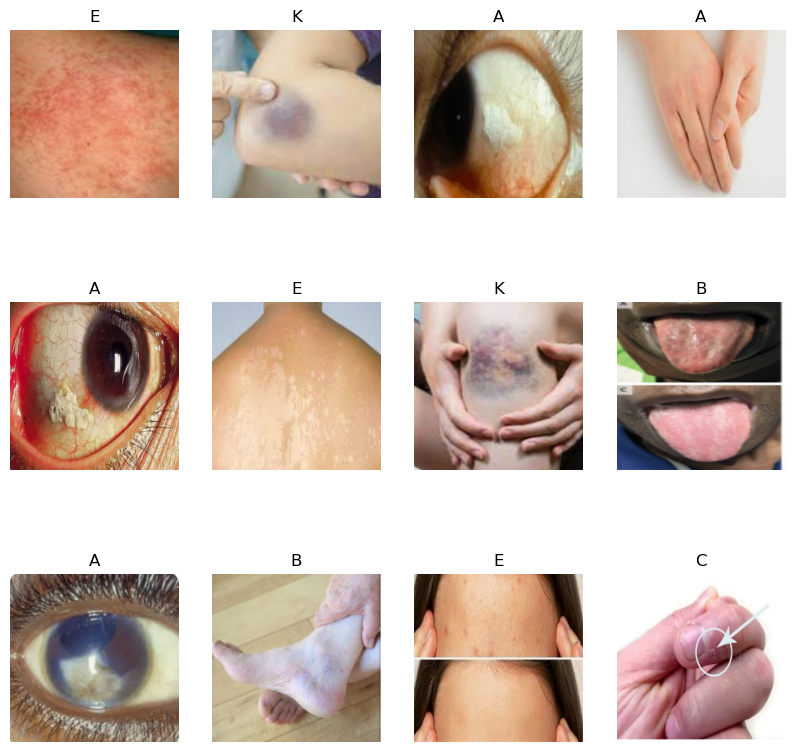

In [124]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # Change this line to (3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [125]:
len(dataset)

10

In [126]:
train_size = 0.8
len(dataset)*train_size

8.0

In [127]:
train_ds = dataset.take(8)
len(train_ds)

8

In [128]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [129]:
val_size=0.1
len(dataset)*val_size

1.0

In [130]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [131]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [132]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)  # Modified this line
    
    return train_ds, val_ds, test_ds


In [133]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [134]:
len(train_ds)

8

In [135]:
len(val_ds)

1

In [136]:
len(test_ds)

1

In [137]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [138]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])


In [139]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])


In [140]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [141]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6  # Change this to 6 since you have 6 classes

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Adjusted output size
])

model.build(input_shape=input_shape)


In [142]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (15, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (15, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (15, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (15, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (15, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (15, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (15, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (15, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (15, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (15, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (15, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (15, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (15, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (15, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (15, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (15, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [144]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=400,
)


Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.2432 - loss: 1.8171 - val_accuracy: 0.2667 - val_loss: 1.7878
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.1394 - loss: 1.7902 - val_accuracy: 0.0667 - val_loss: 1.7911
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.1856 - loss: 1.7898 - val_accuracy: 0.0667 - val_loss: 1.7951
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.1479 - loss: 1.7943 - val_accuracy: 0.0667 - val_loss: 1.7941
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.1630 - loss: 1.7941 - val_accuracy: 0.2667 - val_loss: 1.7851
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.1503 - loss: 1.7844 - val_accuracy: 0.0667 - val_loss: 1.7949
Epoch 7/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.1727 - loss: 1.7834 - val_accuracy: 0.0667 - val_loss: 1.7882
Epoch 8/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1622 - loss: 1.7864 - val_accuracy: 0.0667 - v

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.3749 - loss: 1.4882 - val_accuracy: 0.4000 - val_loss: 1.4720
Epoch 52/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.4621 - loss: 1.4309 - val_accuracy: 0.4667 - val_loss: 1.2782
Epoch 53/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.4981 - loss: 1.3003 - val_accuracy: 0.5333 - val_loss: 1.1346
Epoch 54/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.4986 - loss: 1.1974 - val_accuracy: 0.4667 - val_loss: 1.4427
Epoch 55/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.5463 - loss: 1.2849 - val_accuracy: 0.4000 - val_loss: 1.0876
Epoch 56/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.5146 - loss: 1.2834 - val_accuracy: 0.4667 - val_loss: 1.2269
Epoch 57/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.4033 - loss: 1.3457 - val_accuracy: 0.6000 - val_loss: 1.0211
Epoch 58/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.5437 - loss: 1.1239 - val_accuracy: 0.6667 - val_lo

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.8186 - loss: 0.5726 - val_accuracy: 0.8000 - val_loss: 0.9951
Epoch 102/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.6735 - loss: 0.8150 - val_accuracy: 0.8667 - val_loss: 0.4005
Epoch 103/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.6121 - loss: 0.8513 - val_accuracy: 0.7333 - val_loss: 0.8093
Epoch 104/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8307 - loss: 0.5477 - val_accuracy: 0.8000 - val_loss: 0.9730
Epoch 105/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.6845 - loss: 0.7652 - val_accuracy: 0.8000 - val_loss: 0.9486
Epoch 106/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.7420 - loss: 0.6260 - val_accuracy: 0.8667 - val_loss: 0.9778
Epoch 107/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.8317 - loss: 0.5575 - val_accuracy: 0.7333 - val_loss: 0.8238
Epoch 108/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.6358 - loss: 0.9277 - val_accuracy: 0.8667 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9471 - loss: 0.1917 - val_accuracy: 1.0000 - val_loss: 0.1349
Epoch 152/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9295 - loss: 0.2089 - val_accuracy: 0.9333 - val_loss: 0.2094
Epoch 153/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9019 - loss: 0.2826 - val_accuracy: 1.0000 - val_loss: 0.0808
Epoch 154/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.8381 - loss: 0.3469 - val_accuracy: 1.0000 - val_loss: 0.0470
Epoch 155/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.9290 - loss: 0.2671 - val_accuracy: 0.9333 - val_loss: 0.2054
Epoch 156/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8747 - loss: 0.3677 - val_accuracy: 0.9333 - val_loss: 0.2017
Epoch 157/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8825 - loss: 0.2999 - val_accuracy: 1.0000 - val_loss: 0.0790
Epoch 158/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8432 - loss: 0.4546 - val_accuracy: 0.9333 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9385 - loss: 0.2295 - val_accuracy: 0.8667 - val_loss: 0.1987
Epoch 202/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9678 - loss: 0.1016 - val_accuracy: 0.8667 - val_loss: 0.6433
Epoch 203/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9508 - loss: 0.1839 - val_accuracy: 0.9333 - val_loss: 0.7957
Epoch 204/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9208 - loss: 0.1569 - val_accuracy: 0.8000 - val_loss: 0.5623
Epoch 205/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9254 - loss: 0.2264 - val_accuracy: 0.8667 - val_loss: 1.2077
Epoch 206/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.9061 - loss: 0.2134 - val_accuracy: 0.8000 - val_loss: 1.4756
Epoch 207/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9505 - loss: 0.2483 - val_accuracy: 0.9333 - val_loss: 0.9396
Epoch 208/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.9493 - loss: 0.1512 - val_accuracy: 0.8667 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.9704 - loss: 0.2288 - val_accuracy: 0.8000 - val_loss: 0.6412
Epoch 252/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9493 - loss: 0.0941 - val_accuracy: 0.9333 - val_loss: 0.2821
Epoch 253/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9871 - loss: 0.0675 - val_accuracy: 0.9333 - val_loss: 0.3640
Epoch 254/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9902 - loss: 0.0837 - val_accuracy: 0.9333 - val_loss: 0.5640
Epoch 255/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9778 - loss: 0.0783 - val_accuracy: 0.9333 - val_loss: 0.3661
Epoch 256/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9530 - loss: 0.1283 - val_accuracy: 0.8667 - val_loss: 0.5918
Epoch 257/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.9313 - loss: 0.2267 - val_accuracy: 0.9333 - val_loss: 0.9373
Epoch 258/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.9305 - loss: 0.2837 - val_accuracy: 0.8667 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9959 - loss: 0.0287 - val_accuracy: 0.9333 - val_loss: 0.6344
Epoch 302/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9842 - loss: 0.0184 - val_accuracy: 0.9333 - val_loss: 0.6373
Epoch 303/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 0.9333 - val_loss: 0.6506
Epoch 304/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9981 - loss: 0.0144 - val_accuracy: 0.9333 - val_loss: 0.7186
Epoch 305/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9863 - loss: 0.0406 - val_accuracy: 0.9333 - val_loss: 0.7335
Epoch 306/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.9789 - loss: 0.0406 - val_accuracy: 0.9333 - val_loss: 0.7963
Epoch 307/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9925 - loss: 0.0594 - val_accuracy: 0.9333 - val_loss: 0.8598
Epoch 308/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9878 - loss: 0.0548 - val_accuracy: 0.8000 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.9925 - loss: 0.0308 - val_accuracy: 0.9333 - val_loss: 0.2607
Epoch 352/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9333 - val_loss: 0.3334
Epoch 353/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9333 - val_loss: 0.4185
Epoch 354/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.9971 - loss: 0.0271 - val_accuracy: 0.8667 - val_loss: 0.5069
Epoch 355/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9530 - loss: 0.1994 - val_accuracy: 0.8000 - val_loss: 3.5149
Epoch 356/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8583 - loss: 0.4613 - val_accuracy: 0.8667 - val_loss: 1.3289
Epoch 357/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.8424 - loss: 0.6558 - val_accuracy: 0.8000 - val_loss: 1.6171
Epoch 358/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.8731 - loss: 0.4359 - val_accuracy: 0.8667 -

In [145]:
scores = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8667 - loss: 1.4326


In [146]:
scores

[1.4326395988464355, 0.8666666746139526]

In [147]:
history

In [148]:
history.params

{'verbose': 1, 'epochs': 400, 'steps': 8}

In [149]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [150]:
type(history.history['loss'])

list

In [151]:
len(history.history['loss'])

400

In [152]:
history.history['loss'][:5]

[1.828370451927185,
 1.790605902671814,
 1.7892838716506958,
 1.7890594005584717,
 1.7927851676940918]

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

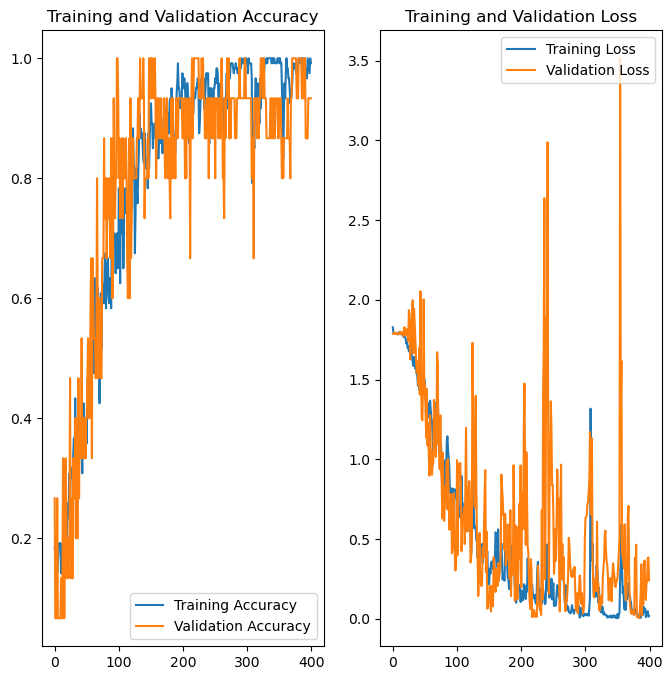

In [154]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: E
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
predicted label: E


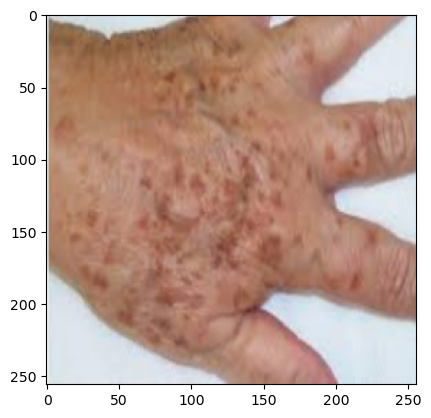

In [155]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [156]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


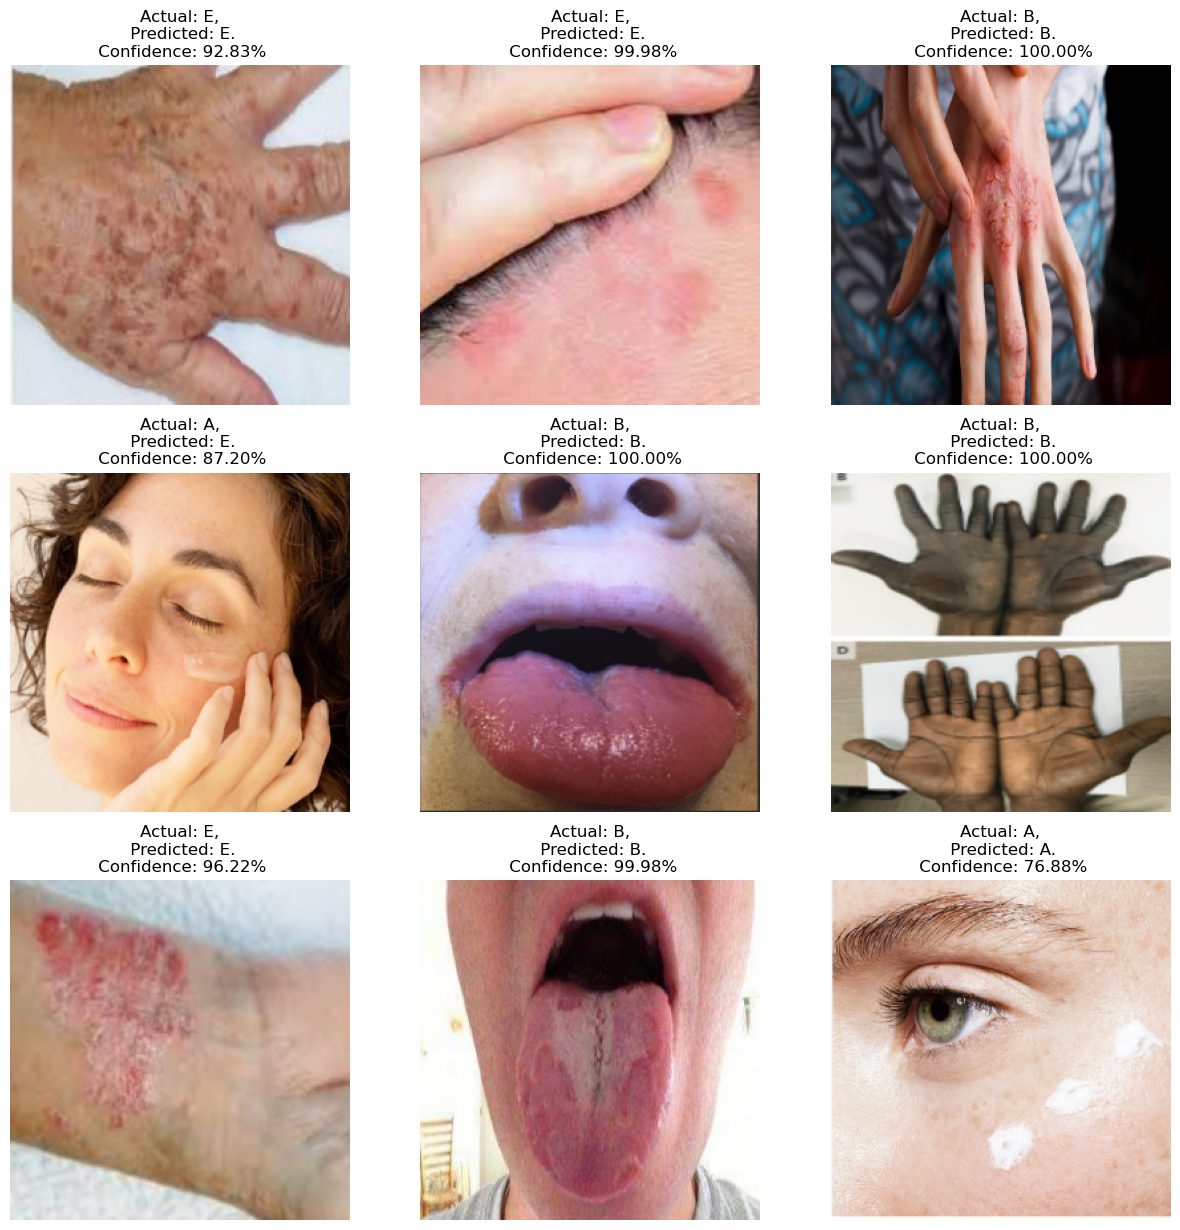

In [157]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())  # Assuming you have a predict function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")  # Adjusted formatting
        
        plt.axis("off")

In [158]:
import os

# Extract numeric parts from filenames and convert to integers
existing_versions = [int(filename.split('.')[0]) for filename in os.listdir("../models") if filename.endswith('.keras')]

# Get the maximum existing version or default to 0 if no models exist
model_version = max(existing_versions, default=0) + 1

# Save the model with the next version number
model.save(f"../models/{model_version}.h5")
